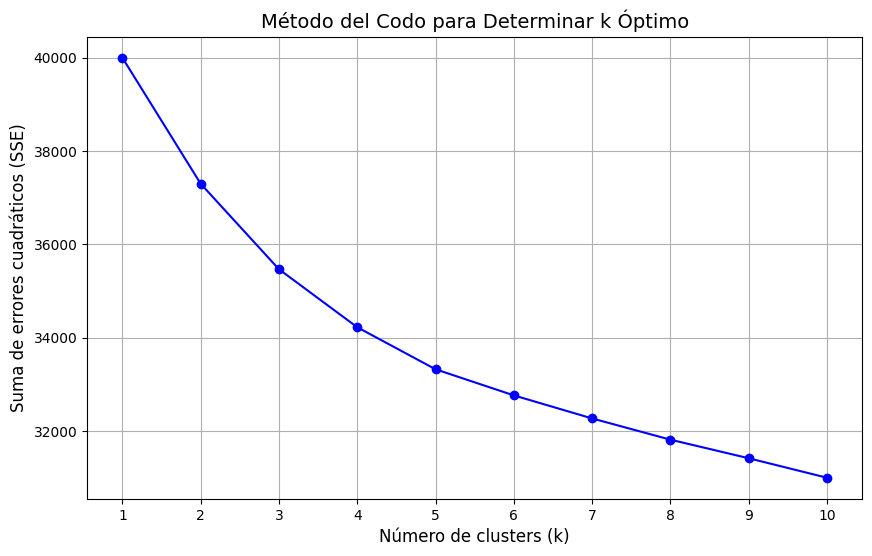

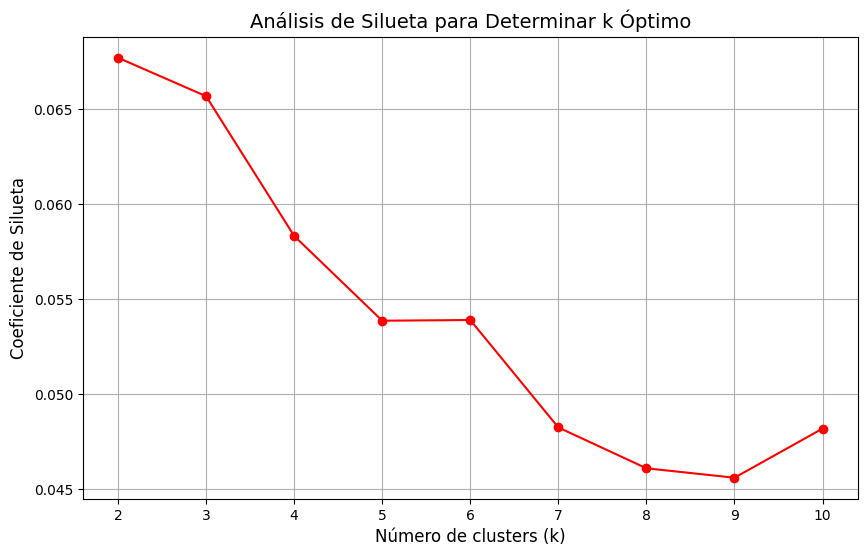

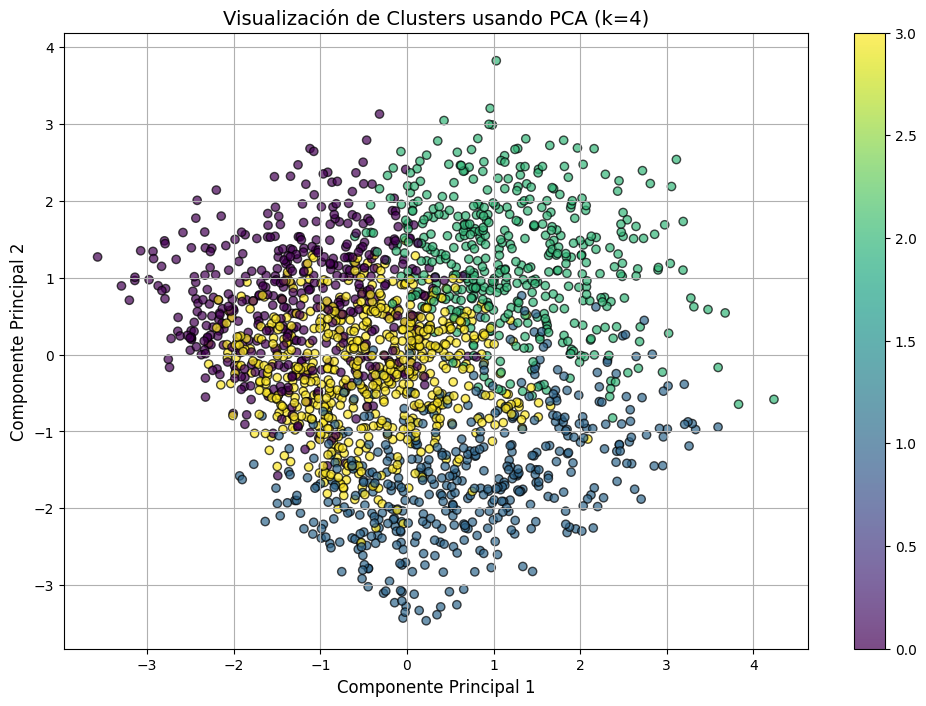


Análisis de clusters por características promedio:
         battery_power      blue  clock_speed  dual_sim        fc    four_g  \
Cluster                                                                       
0          1190.405405  0.475225     1.395721  0.472973  2.337838  0.725225   
1          1226.327660  0.523404     1.577234  0.521277  4.151064  0.000000   
2          1260.106667  0.495556     1.585556  0.473333  9.746667  0.662222   
3          1265.841195  0.487421     1.525157  0.551887  1.955975  0.665094   

         int_memory     m_dep   mobile_wt   n_cores  ...    px_height  \
Cluster                                              ...                
0         33.247748  0.510360  140.695946  4.858108  ...  1001.153153   
1         32.538298  0.508936  140.019149  4.580851  ...   667.042553   
2         28.724444  0.502889  143.471111  4.393333  ...   588.422222   
3         33.194969  0.489623  137.827044  4.330189  ...   420.446541   

            px_width          ram 

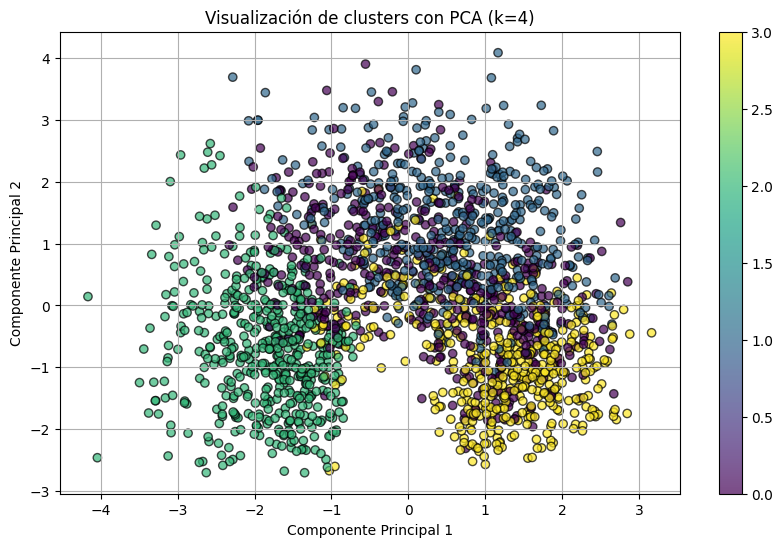

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.pairwise import pairwise_distances

# Cargar los datos
df = pd.read_csv('train.csv')

# Preprocesamiento
def preprocess_mobile_data(df):
    X = df.drop('price_range', axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, df['price_range']

X_scaled, y = preprocess_mobile_data(df)

# Método del Codo
def elbow_method(data):
    sse = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, 'bo-')
    plt.xlabel('Número de clusters (k)', fontsize=12)
    plt.ylabel('Suma de errores cuadráticos (SSE)', fontsize=12)
    plt.title('Método del Codo para Determinar k Óptimo', fontsize=14)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

elbow_method(X_scaled)

# Análisis de Silueta
def silhouette_analysis(data):
    silhouette_scores = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Número de clusters (k)', fontsize=12)
    plt.ylabel('Coeficiente de Silueta', fontsize=12)
    plt.title('Análisis de Silueta para Determinar k Óptimo', fontsize=14)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

silhouette_analysis(X_scaled)

# Entrenamiento del modelo con K óptimo
k_optimo = 4  # ajusta según los gráficos
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Visualización con PCA
def plot_clusters(data, clusters):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters,
                         cmap='viridis', alpha=0.7, edgecolors='k')
    plt.xlabel('Componente Principal 1', fontsize=12)
    plt.ylabel('Componente Principal 2', fontsize=12)
    plt.title(f'Visualización de Clusters usando PCA (k={k_optimo})', fontsize=14)
    plt.colorbar(scatter)
    plt.grid(True)
    plt.show()

plot_clusters(X_scaled, clusters)

# Análisis de resultados
df['Cluster'] = clusters
cluster_analysis = df.groupby('Cluster').mean()
print("\nAnálisis de clusters por características promedio:")
print(cluster_analysis)

# Comparación con etiquetas reales (opcional)
comparison_df = pd.DataFrame({
    'Cluster': clusters,
    'Categoría Real': y
})
cross_tab = pd.crosstab(comparison_df['Cluster'], comparison_df['Categoría Real'])
print("\nTabla cruzada entre clusters y categorías reales (price_range):")
print(cross_tab)

def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_labels:
        for j in unique_labels:
            if i != j:
                cluster_i = X[labels == i]
                cluster_j = X[labels == j]
                distance = np.min(pairwise_distances(cluster_i, cluster_j))
                inter_cluster_distances.append(distance)

    for i in unique_labels:
        cluster = X[labels == i]
        distance = np.max(pairwise_distances(cluster))
        intra_cluster_distances.append(distance)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)


def evaluar_modelo_kmeans(df, etiqueta='price_range', k=4, use_pca=False, pca_components=10, use_minibatch=False):
    print("🚀 Iniciando evaluación del modelo K-Means...\n")
    
    # --- Preprocesamiento ---
    X = df.drop(etiqueta, axis=1)
    y = df[etiqueta]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if use_pca:
        print(f"📉 Aplicando PCA con {pca_components} componentes...")
        pca = PCA(n_components=pca_components)
        X_scaled = pca.fit_transform(X_scaled)

    # --- Entrenamiento ---
    print(f"\n🔁 Entrenando K-Means con k = {k}...")
    clusterer = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=50, batch_size=128) if use_minibatch \
                else KMeans(n_clusters=k, random_state=42, n_init=50)

    clusters = clusterer.fit_predict(X_scaled)

    # --- Evaluaciones ---
    inertia = clusterer.inertia_
    silhouette = silhouette_score(X_scaled, clusters)
    db_index = davies_bouldin_score(X_scaled, clusters)
    homo = homogeneity_score(y, clusters)
    comp = completeness_score(y, clusters)
    v_measure = v_measure_score(y, clusters)
    dunn = dunn_index(X_scaled, clusters)

    print(f"\n📊 Métricas de evaluación:")
    print(f"- Inercia (SSE): {inertia:.2f}")
    print(f"- Silhouette Score: {silhouette:.4f}")
    print(f"- Davies-Bouldin Index: {db_index:.4f}")
    print(f"- Homogeneidad: {homo:.4f}")
    print(f"- Completitud: {comp:.4f}")
    print(f"- V-Measure: {v_measure:.4f}")
    print(f"- Dunn Index: {dunn:.4f}")

    # --- Visualización ---
    print("\n📌 Mostrando visualización con PCA (2D)...")
    pca_viz = PCA(n_components=2)
    reduced = pca_viz.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title(f"Visualización de clusters con PCA (k={k})")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.colorbar()
    plt.grid(True)
    plt.show()

    return {
        'modelo': clusterer,
        'clusters': clusters,
        'X_scaled': X_scaled,
        'etiquetas_reales': y
    }

resultado = evaluar_modelo_kmeans(
    df,
    etiqueta='price_range',
    k=4,
    use_pca=True,
    pca_components=10,
    use_minibatch=True
)

In [15]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# Suponiendo que ya tienes:
# - X_scaled: datos normalizados
# - clusters: etiquetas del clustering
# - y: variable price_range como etiquetas reales

# 1. Inercia (ya la tienes con kmeans.inertia_)
print(f"Inercia (SSE): {kmeans.inertia_:.2f}")

# 2. Silhouette Score
silhouette = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette:.4f}")

# 3. Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

# 4. Homogeneidad, Completitud, V-Measure
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)
v_measure = v_measure_score(y, clusters)

print(f"Homogeneidad: {homogeneity:.4f}")
print(f"Completitud: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")

# 5. Dunn Index (función personalizada)
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_labels:
        for j in unique_labels:
            if i != j:
                cluster_i = X[labels == i]
                cluster_j = X[labels == j]
                distance = np.min(pairwise_distances(cluster_i, cluster_j))
                inter_cluster_distances.append(distance)

    for i in unique_labels:
        cluster = X[labels == i]
        distance = np.max(pairwise_distances(cluster))
        intra_cluster_distances.append(distance)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

dunn = dunn_index(X_scaled, clusters)
print(f"Dunn Index: {dunn:.4f}")

Inercia (SSE): 34223.17
Silhouette Score: 0.0583
Davies-Bouldin Index: 3.2819
Homogeneidad: 0.0079
Completitud: 0.0079
V-Measure: 0.0079
Dunn Index: 0.2176
